导入包

In [1]:
import argparse
import datetime
import logging
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv3D, Conv3DTranspose, multiply, Embedding, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
from matplotlib.patches import Patch

from utils.load_data import load_data, split_data, create_image_cube
from utils.metrics import reports, save_report, read_report, visualize_report
from utils.visualization import RGBImage, color_map_16, color_map_17

import spectral
from PIL import Image

# save_path = os.path.join("./outputs")


作数据集的演示图以及图例

In [2]:
# dataset = "indian_pines"
dataset = "salinas"

data, label, _ = load_data(dataset)
print(data.shape)

(512, 217, 204)


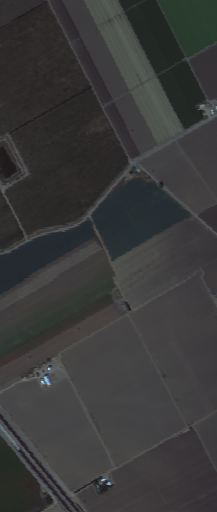

True

In [3]:
# 获取指定波段的数据
if dataset == "indian_pines":
    bands = (29, 19, 9)
    # bands = (50, 30, 15)
    # bands = (45, 21, 7)
elif dataset == "salinas":
    bands = (29, 19, 9)
    # bands = (55, 35, 15)
    # bands = (50, 30, 10)
    # bands = (45, 21, 7)
    # bands = (87, 56, 4)
    # bands = (50, 30, 10)

data_rgb = data[:, :, bands]

# 展示伪RGB图像
# rgb = spectral.imshow(data, bands)

# 将数据可视化为RGB图像
rgb = cv2.normalize(data_rgb, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
display(Image.fromarray(rgb))

# 保存RGB图像为PNG文件
save_path = os.path.join("./outputs", dataset + "_fake_rgb.png")
bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
cv2.imwrite(save_path, bgr)

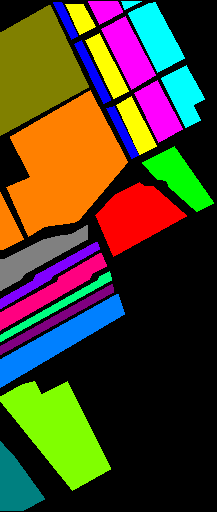

In [9]:
# 将标签渲染为RGB图像
# label_real = label[label!=0] - 1

rgb_image = RGBImage(label)
# rgb_image = (rgb_image * 255).astype(np.uint8)
# rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(rgb_image))

# # 保存RGB图像为PNG文件
save_path = os.path.join("./outputs", dataset + "_label.png")
img = Image.fromarray(np.uint8(rgb_image))
img.save(save_path)

# 保存RGB图像为PNG文件
# save_path = "./outputs/indian_pines_label_rgb.png"
# cv2.imwrite(save_path, rgb_image)

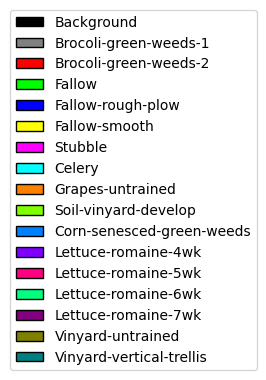

In [4]:
color_map = np.array(color_map_17) / 255.0
if dataset == "indian_pines":
    label_name = ['Background', 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture',
              'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill',
              'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 
              'Stone-Steel-Towers']
elif dataset == "salinas":
    label_name = ['Background', 'Brocoli-green-weeds-1', 'Brocoli-green-weeds-2', 'Fallow', 'Fallow-rough-plow',
                  'Fallow-smooth', 'Stubble', 'Celery', 'Grapes-untrained', 'Soil-vinyard-develop',
                  'Corn-senesced-green-weeds', 'Lettuce-romaine-4wk', 'Lettuce-romaine-5wk',
                  'Lettuce-romaine-6wk', 'Lettuce-romaine-7wk', 'Vinyard-untrained', 'Vinyard-vertical-trellis']

def create_legend(dataset):
    handles = [Patch(facecolor=color_map[i], edgecolor='k', label=label_name[i]) for i in range(len(label_name))]
    return handles

handles = create_legend(dataset)
fig = plt.figure(figsize=(1, 1))
fig.legend(handles=handles, loc='center', ncol=1)
plt.axis('off')
plt.show()




KeyError: (17, 1)

d:\ProgramFiles\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\ProgramFiles\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\ProgramFiles\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 39068 (\N{CJK UNIFIED IDEOGRAPH-989C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\ProgramFiles\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\ProgramFiles\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(b

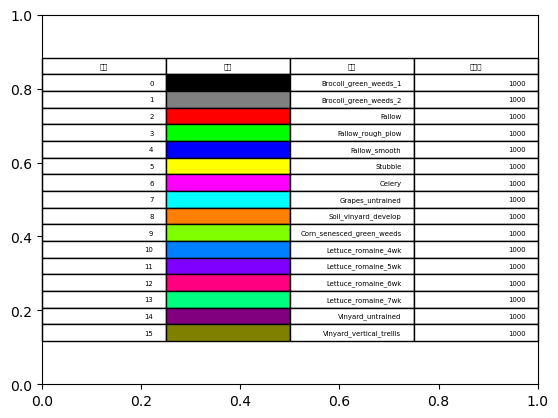

In [6]:
import matplotlib.pyplot as plt
import numpy as np

color_map_17 = [
    [0, 0, 0], [128, 128, 128], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255],
    [0, 255, 255], [255, 128, 0], [128, 255, 0], [0, 128, 255], [128, 0, 255], [255, 0, 128], [0, 255, 128],
    [128, 0, 128], [128, 128, 0], [0, 128, 128]
]
if dataset == "indian_pines":
    label_name = [
        'Background', 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods',
        'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'
    ]
elif dataset == "salinas":
    label_name = ['Background', 'Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']

# 假设每个类别具有相同的样本数量
sample_counts = [1000] * len(label_name)

# 将颜色从0-255范围转换为0-1范围
color_map_17 = np.array(color_map_17) / 255

fig, ax = plt.subplots()

# 创建表格
table_data = [[''] * 4 for _ in range(len(label_name))]
for i in range(len(label_name)):
    table_data[i][0] = i
    table_data[i][1] = ' '
    table_data[i][2] = label_name[i]
    table_data[i][3] = sample_counts[i]

table = ax.table(cellText=table_data, colLabels=['序号', '颜色', '类名', '样本数'], loc='center')

# 设置颜色
for i in range(len(color_map_17)):
    table[(i + 1, 1)].set_facecolor(color_map_17[i])

# 隐藏坐标轴和边框
ax.axis('off')
ax.axis('tight')

# 设置标题
plt.title('Indian Pines Dataset Sample Table')

# 展示图形
plt.show()

In [ ]:
# 
if __name__ == '__main__':

    # 初始化日志
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    
    # 1 数据预处理
    # 加载数据集
    data_ori, label_ori, num_classes = load_data(args.dataset, preprocessing=args.preprocess)

    data_ori, label_ori = create_image_cube(data_ori, label_ori, window_size=args.spatial_size, remove_zero_labels = False)
    
    # # 0 代表背景，不参与训练
    data = data_ori[label_ori!=0]
    label = label_ori[label_ori!=0] - 1


    for pos in range(args.repeat):
        save_path = os.path.join(args.checkpoint_dir, str(pos))

        test_percent = 1 - args.train_percent
        x_train, x_test, y_train, y_test = split_data(data, label,
                                                test_percent=test_percent,
                                                random_state=args.random_state + pos)
        x_test  = x_test[..., np.newaxis]
        x_train = x_train[..., np.newaxis]

        # 输出训练集和测试集的形状和训练设置
        logging.info(f'x_train shape: {x_train.shape}')
        logging.info(f'y_train shape: {y_train.shape}')
        logging.info(f'x_test shape: {x_test.shape}')
        logging.info(f'y_test shape: {y_test.shape}')
        
        input_shape = x_train.shape[1:]
        latent_dim = 100

        run_name = f'GAN3D_2D_HS_{args.dataset}_b{args.batch_size}_e{args.num_epochs}_w{args.spatial_size}_n{pos}'

        if not args.test_only:
        # 训练部分
            GAN = GAN3D_2D_HS(input_shape, num_classes, latent_dim, checkpoint_dir=save_path)
            GAN.train(x_train, y_train, args.num_epochs, args.batch_size, args.save_interval, run_name = run_name)
        
        # 测试部分
        # del GAN
        GAN_D = GAN3D_2D_HS(input_shape, num_classes, latent_dim, checkpoint_dir=save_path).discriminator
        GAN_D.load_weights(os.path.join(save_path, 'D_best.hdf5'))


        _, y_pred = GAN_D.predict(x_test)
        report = reports(np.argmax(y_pred, axis=1), y_test)
        save_report(*report, save_path)
        # Read the report from the CSV file
        report_dict = read_report(save_path)

        # Visualize the report in Python
        visualize_report(report_dict)

        # 生成预测图像
        _, y_pred = GAN_D.predict(data_ori[..., np.newaxis])

        image_pred = np.argmax(y_pred, axis=1).reshape(145,145)

        # 将背景像素设置为0，分类标签从1开始
        label_ori = label_ori.reshape(145,145)
        image_pred += 1
        image_pred[ label_ori == 0] = 0

        rgb_pred = RGBImage(image_pred)
        rgb_true = RGBImage(label_ori)
        cv2.imwrite(os.path.join(save_path, "y_pred.png"), rgb_pred)
        cv2.imwrite(os.path.join(save_path, "y_true.png"), rgb_true)

In [12]:
import tensorflow as tf
print(tf.__version__)

2.7.0
